In [2]:
%load_ext autoreload
%autoreload 2

from src.models.factor_analysis import FactorAnalysis
from src.utils import optimal_assignment
import torch
import matplotlib.pyplot as plt
import pyro
from scipy.stats import pearsonr

In [3]:
n_samples = 1000
n_features =100
n_factors = 3

sim_model = FactorAnalysis(
    data=torch.zeros([n_samples, n_features]),
    n_factors=n_factors,
    return_values=True,
    prior_scale_scale=0.05,
    prior_w_scale=1.,
    prior_z_scale=1.,
    )

sim_model_model_unconditioned = pyro.poutine.uncondition(sim_model._model)

sim_data = sim_model_model_unconditioned()

In [4]:
pyro.clear_param_store()

model = FactorAnalysis(
    data=sim_data['y'],
    n_factors=n_factors,
    prior_w_scale=5.,
    prior_z_scale=5.,
)

model.train(num_particles=15, lr=5e-3)

Relative loss: 0.046. Epoch: 683it [00:24, 27.88it/s]


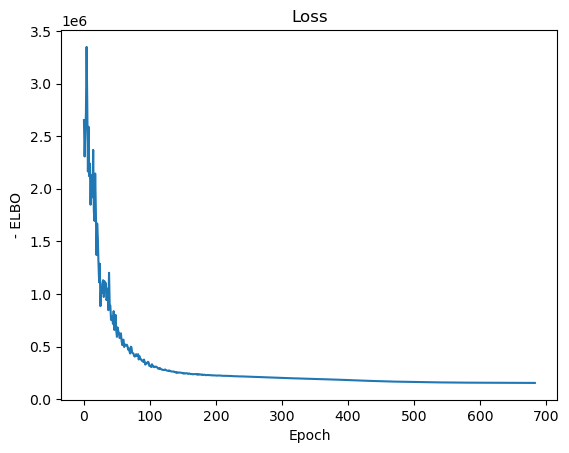

In [5]:
plt.plot(torch.arange(len(model.losses)), model.losses)
plt.title('Loss')
plt.ylabel('- ELBO')
plt.xlabel('Epoch')
plt.show()

In [6]:
w = sim_data['w']
z = sim_data['z']
scale = sim_data['scale']

w_loc = pyro.param('w_loc').detach().squeeze()
w_scale = pyro.param('w_scale').detach().squeeze()
z_loc = pyro.param('z_loc').detach().squeeze()
z_scale = pyro.param('z_scale').detach().squeeze()
scale_loc = pyro.param('scale_loc').detach().squeeze()
scale_scale = pyro.param('scale_scale').detach().squeeze()

inds, corrs = optimal_assignment(z, z_loc, -2)

for k in range(n_factors):
    if corrs[k] < 0:
        sign = -1
    else:
        sign = 1

    z_loc[k] = sign * z_loc[inds[k]]
    z_scale[k] = z_scale[inds[k]]
    w_loc[k] = sign * w_loc[inds[k]]
    w_scale[k] = w_scale[inds[k]]    

In [9]:
corrs

array([ 0.9824264 ,  0.96052384, -0.98375046], dtype=float32)

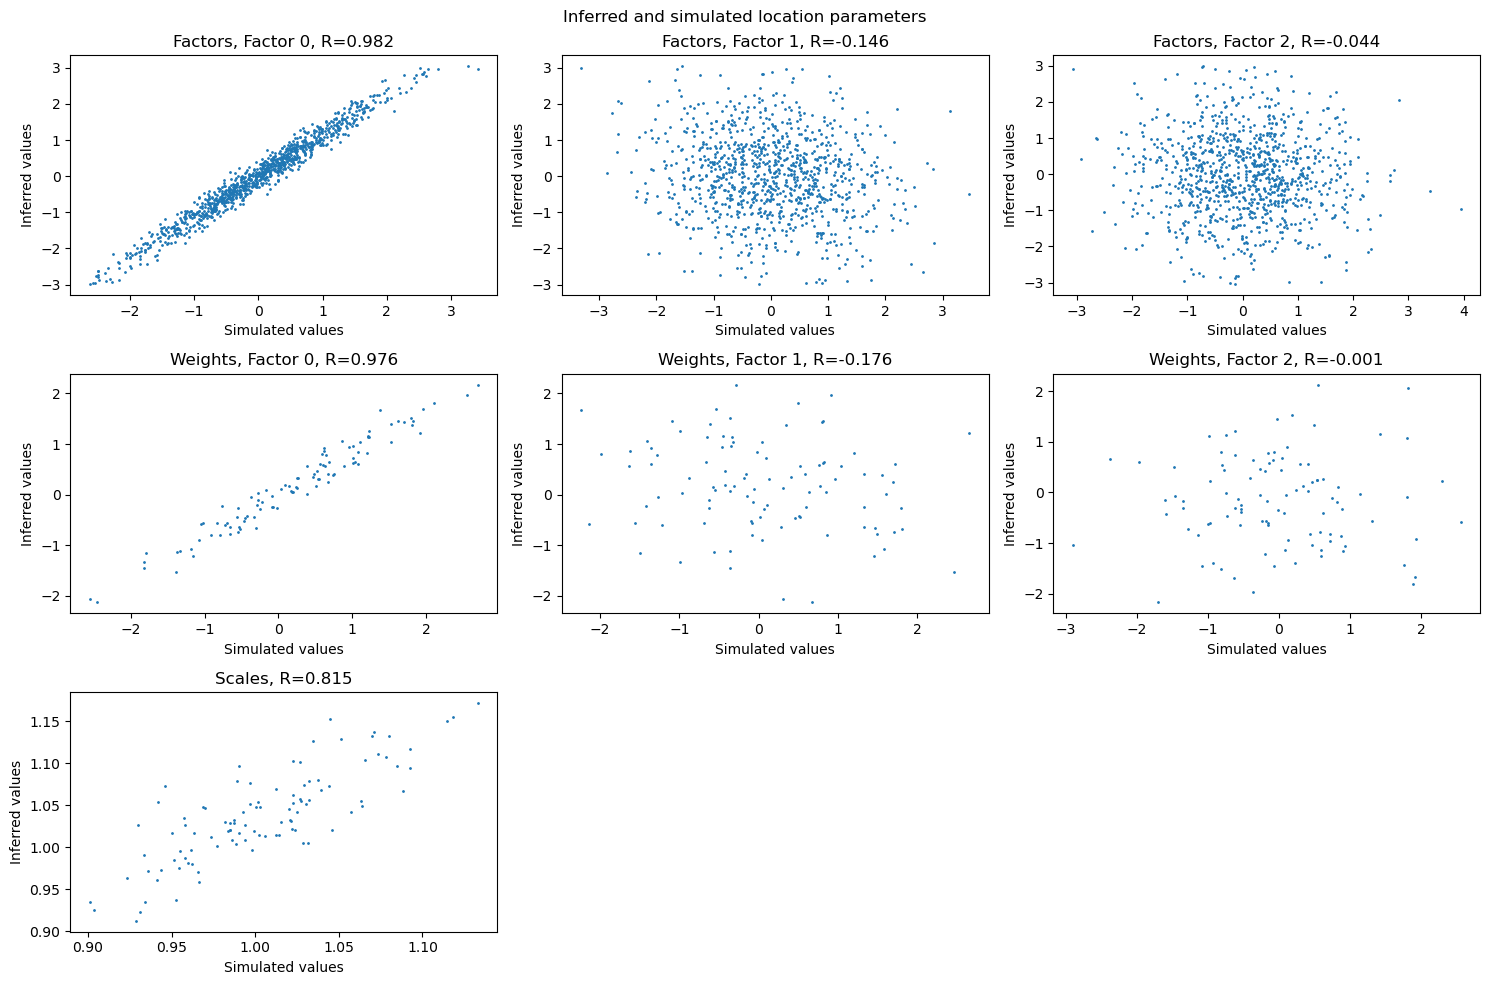

In [7]:
fig, axs = plt.subplots(3, n_factors, figsize=(15, 10))

for k in range(n_factors):
    z_corr = round(pearsonr(z_loc[k], z[k])[0], 3)
    axs[0, k].scatter(z[k], z_loc[k], s=1)
    axs[0, k].set_title(f'Factors, Factor {k}, R={z_corr}')

    z_corr = round(pearsonr(w[k], w_loc[k])[0], 3)
    axs[1, k].scatter(w[k], w_loc[k], s=1)
    axs[1, k].set_title(f'Weights, Factor {k}, R={z_corr}')

scale_corr = round(pearsonr(scale, scale_loc)[0], 3)
axs[2, 0].scatter(scale, scale_loc.exp(), s=1)
axs[2, 0].set_title(f'Scales, R={scale_corr}')

for ax in axs.flatten():
    ax.set_xlabel('Simulated values')
    ax.set_ylabel('Inferred values')

axs[2, 1].axis('off')
axs[2, 2].axis('off')

fig.suptitle('Inferred and simulated location parameters')
plt.tight_layout()

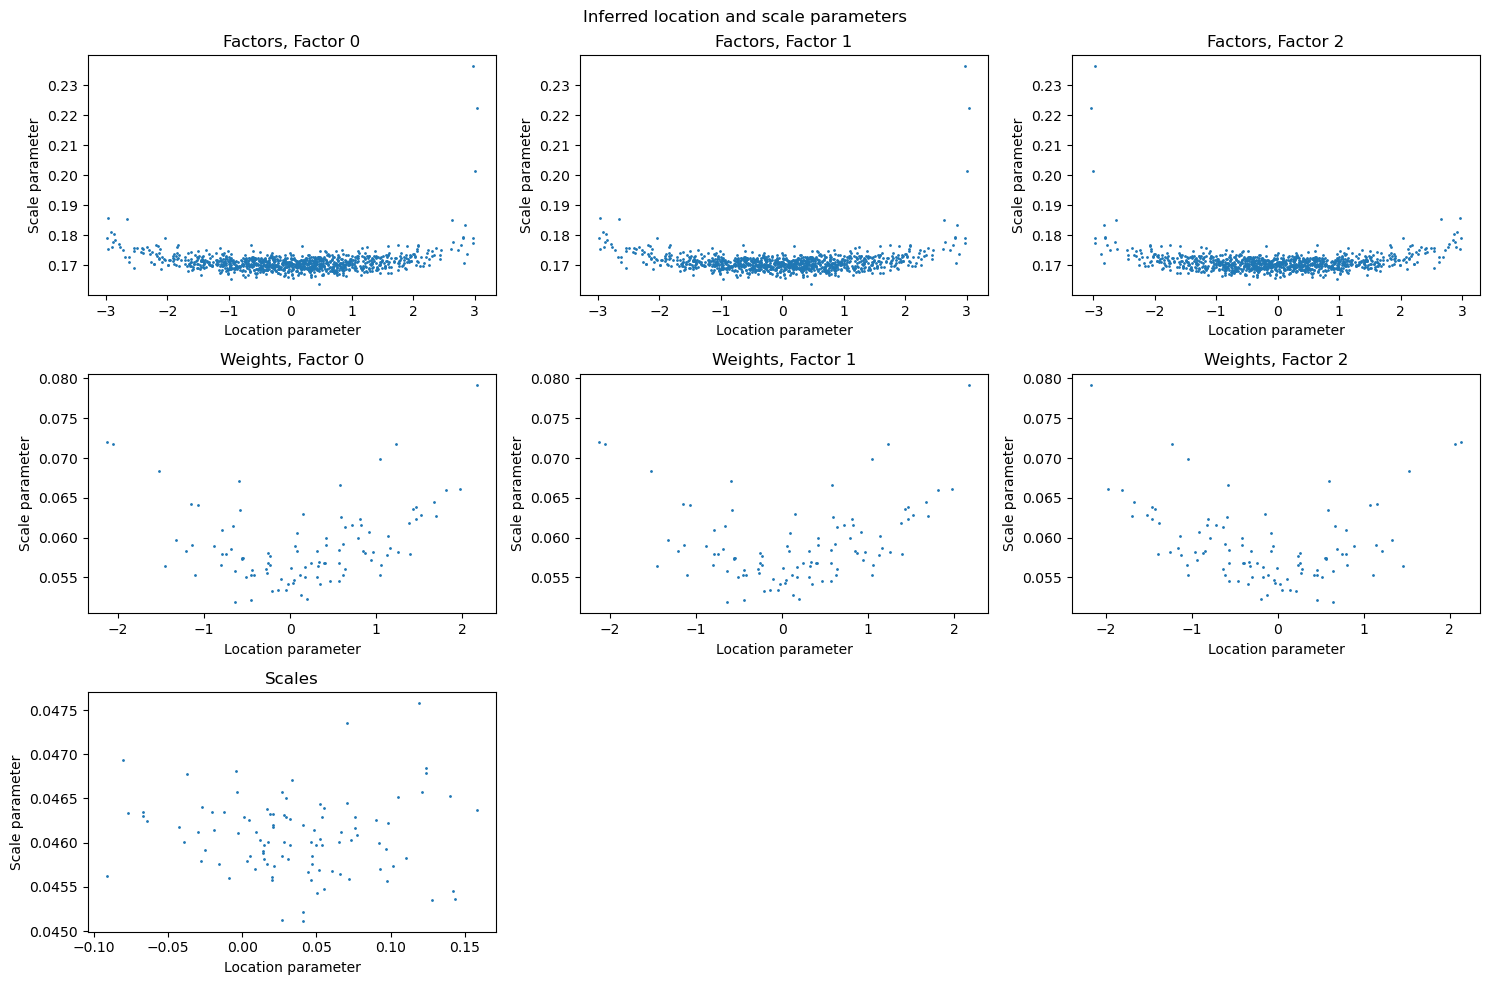

In [8]:
fig, axs = plt.subplots(3, n_factors, figsize=(15, 10))

for k in range(n_factors):
    axs[0, k].scatter(z_loc[k], z_scale[k], s=1)
    axs[0, k].set_title(f'Factors, Factor {k}')

    axs[1, k].scatter(w_loc[k], w_scale[k], s=1)
    axs[1, k].set_title(f'Weights, Factor {k}')

axs[2, 0].scatter(scale_loc, scale_scale, s=1)
axs[2, 0].set_title(f'Scales')

for ax in axs.flatten():
    ax.set_xlabel('Location parameter')
    ax.set_ylabel('Scale parameter')

axs[2, 1].axis('off')
axs[2, 2].axis('off')

fig.suptitle('Inferred location and scale parameters')
plt.tight_layout()